In [1]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
print('pytorch version:', torch.__version__)
global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', global_device)
from torch.utils.data import DataLoader, random_split, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import MultilabelAveragePrecision

pytorch version: 2.2.0.dev20231027+cu121
Device: cuda:0


In [93]:
# Matplotlib settings
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})

# Data loading

In [94]:
df_trainval = pd.read_csv('data/train.csv')
df_train, df_val = train_test_split(df_trainval, test_size=0.2, random_state=42)
df_train['tags'] = df_train['tags'].apply(lambda x: np.array(list(map(int, x.split(',')))))
df_val['tags'] = df_val['tags'].apply(lambda x: np.array(list(map(int, x.split(',')))))

df_test = pd.read_csv('data/test.csv')

In [95]:
global_idx2embeds = {} # {idx: np.ndarray[n, 768])}
for npy_file in tqdm(glob('data/track_embeddings/*')):
    track_idx = int(npy_file.split('\\')[1].split('.')[0])
    embeds = np.load(npy_file)
    global_idx2embeds[track_idx] = embeds

100%|██████████| 76714/76714 [01:25<00:00, 893.81it/s]


In [96]:
emb_train_mean = 0
for track_idx in tqdm(df_train['track']):
    emb_train_mean += global_idx2embeds[track_idx].mean(axis=0)
emb_train_mean /= len(df_train['track'])
emb_train_mean.shape

100%|██████████| 40907/40907 [00:37<00:00, 1079.67it/s]


(768,)

In [97]:
num_of_tags = np.zeros(256)
for tags in df_train['tags'].to_list():
    onehot_tags = np.zeros(256)
    onehot_tags[tags] = 1
    num_of_tags += onehot_tags

In [57]:
def tag_in_row(a, tag):
    idxs = []
    for i, row in enumerate(a):
        if tag in row:
            idxs.append(i)
    return idxs

In [87]:
def tag_in_row(a, tag):
    idxs = []
    for i, row in enumerate(a):
        if tag in row:
            idxs.append(i)
    return idxs

df_train_pos = df_train.iloc[tag_in_row(df_train['tags'], 209)]
df_train = df_train.iloc[range(22000)]
for i in range(100):
    df_train = pd.concat([df_train, df_train_pos], ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)
len(df_train)

84307

In [102]:
class TrackDataset(torch.utils.data.Dataset):
    def __init__(self, df_tags, test=False):
        self.df_tags = df_tags
        self.test = test

    def __len__(self):
        return len(self.df_tags)

    def __getitem__(self, idx):
        track_idx = self.df_tags.iloc[idx]['track']
        embeds = global_idx2embeds[track_idx]
        if self.test:
            return track_idx, embeds
        labels_onehot = np.zeros(256)
        labels_onehot[self.df_tags.iloc[idx]['tags']] = 1
        return track_idx, embeds, labels_onehot

In [103]:
def collate(batch):
    track_idxs = torch.IntTensor(np.vstack([triplet[0] for triplet in batch]))
    embeds_list = [torch.FloatTensor(triplet[1] - emb_train_mean).to(global_device) for triplet in batch]
    labels_onehot = torch.FloatTensor(np.vstack([triplet[2][0] for triplet in batch])).to(global_device)
    return track_idxs, embeds_list, labels_onehot

def collate_test(batch):
    track_idxs = torch.IntTensor(np.vstack([triplet[0] for triplet in batch]))
    embeds_list = [torch.FloatTensor(triplet[1] - emb_train_mean).to(global_device) for triplet in batch]
    return track_idxs, embeds_list

batch_size = 256

dataset_train = TrackDataset(df_train)
dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True, collate_fn=collate)

dataset_val = TrackDataset(df_val)
dataloader_val = DataLoader(dataset_val, batch_size, shuffle=False, collate_fn=collate)
dataloader_valtest = DataLoader(dataset_val, batch_size, shuffle=False, collate_fn=collate_test)

dataset_test = TrackDataset(df_test, test=True)
dataloader_test = DataLoader(dataset_test, batch_size, shuffle=False, collate_fn=collate_test)

In [109]:
class TrackToTags(pl.LightningModule):
    def __init__(self, num_classes=256, input_dim=768, hidden_dim=512):
        super().__init__()
        self.num_classes = num_classes
        self.bn = nn.LayerNorm(hidden_dim)
        self.projector =  nn.Linear(input_dim, hidden_dim)
        self.lin = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )
        self.fc = nn.Linear(hidden_dim, num_classes)

        self.pos_weights = torch.FloatTensor(np.ones(256)).to(global_device)
        self.loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weights)

        self.metric = average_precision_score
        self._transit_val = {'preds': [], 'labels': []}
        
    def forward(self, embeds_list):
        x = [self.projector(x) for x in embeds_list]
        x = [v.mean(0).unsqueeze(0) for v in x]
        x = self.bn(torch.cat(x, dim = 0))
        x = self.lin(x)
        outs = self.fc(x)
        return outs

    def training_step(self, batch, batch_idx):
        track_idxs, embeds_list, labels_onehot = batch
        pred_logits = self(embeds_list)
        loss = self.loss(pred_logits, labels_onehot)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        track_idxs, embeds_list, labels_onehot = batch
        pred_logits = self(embeds_list)
        loss = self.loss(pred_logits, labels_onehot)
        self.log("val_loss", loss, prog_bar=True)
        
        pred_probs = torch.sigmoid(pred_logits)
        self._transit_val['labels'].append(np.array(labels_onehot.int().cpu()))
        self._transit_val['preds'].append(np.array(pred_probs.cpu()))

    def on_validation_epoch_end(self):
        preds = np.vstack(self._transit_val['preds'])
        labels = np.vstack(self._transit_val['labels'])
        ap = self.metric(labels, preds)
        self.log('val_ap', ap, prog_bar=True)
        self._transit_val['labels'] = []
        self._transit_val['preds'] = []

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)
        
        return {"optimizer": optimizer,
                "lr_scheduler": {
                                "scheduler": scheduler,
                                "interval": "epoch",
                                "frequency": 10
                                },
               }

In [110]:
model = TrackToTags.load_from_checkpoint('lightning_logs/baseline_norm/epoch=19-val_loss=0.046-val_ap=0.225.ckpt')

In [91]:
checkpoint_callback = ModelCheckpoint(dirpath='lightning_logs/baseline_norm_label209/',
                                      filename='{epoch}-{val_loss:.3f}-{val_ap:.3f}', 
                                      save_top_k=-1, 
                                      monitor="val_ap", 
                                      every_n_epochs=1)
trainer = pl.Trainer(accelerator="gpu", devices=1, val_check_interval=1.0, 
                     max_epochs=20, log_every_n_steps=100,
                     callbacks=[checkpoint_callback])
model = TrackToTags()
trainer.fit(model, dataloader_train, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | bn        | LayerNorm         | 1.0 K 
1 | projector | Linear            | 393 K 
2 | lin       | Sequential        | 164 K 
3 | fc        | Linear            | 129   
4 | loss      | BCEWithLogitsLoss | 0     
------------------------------------------------
559 K     Trainable params
0         Non-trainable params
559 K     Total params
2.237     Total estimated model params size (MB)


Epoch 13:  32%|███▏      | 106/330 [00:30<01:05,  3.44it/s, v_num=130, train_loss=3.72e-5, val_loss=0.0657, val_ap=0.0134] 

In [111]:
def predict(model, loader):
    model.to(global_device)
    model.eval()
    track_idxs = []
    predictions = []
    with torch.no_grad():
        for data in loader:
            track_idx, embeds = data
            embeds = [x.to(global_device) for x in embeds]
            pred_logits = model(embeds)
            pred_probs = torch.sigmoid(pred_logits)
            predictions.append(pred_probs.cpu().numpy())
            track_idxs.append(track_idx.numpy())
    predictions = np.vstack(predictions)
    track_idxs = np.vstack(track_idxs).ravel()
    return track_idxs, predictions

In [112]:
val_true = np.array([y[2] for y in dataset_val])
track_idxs_val, val_pred = predict(model, dataloader_valtest)

In [115]:
average_precision_score(val_true, val_pred)

0.32165612764046464

In [116]:
label2ap = []
for label in range(256):
    label2ap.append(average_precision_score(val_true[:,label], val_pred[:,label]))

In [124]:
label2ap[209]

0.09887906591599901

Text(0.5, 0, 'label')

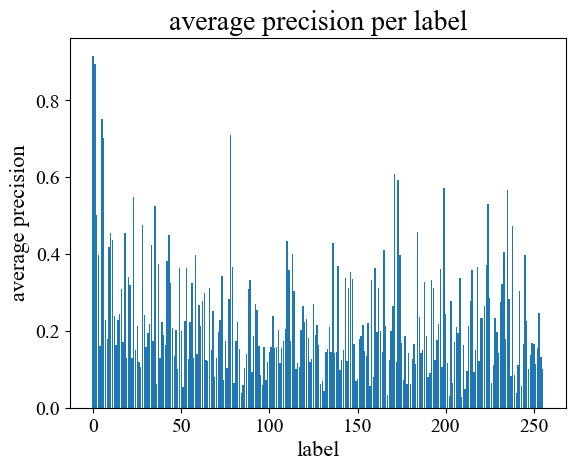

In [21]:
plt.bar(range(256), label2ap)
plt.title("average precision per label")
plt.ylabel("average precision")
plt.xlabel("label")

In [113]:
average_precision_score(val_true, val_pred)

0.32165612764046464

In [117]:
np.mean(label2ap)

0.32165612764046464

In [26]:
np.argmin(label2ap), np.min(label2ap)


(209, 0.026990625321978212)

In [56]:
val_true.shape

(10227, 256)

In [54]:
average_precision_score(val_true[:100], val_pred[:100], default="macro")

0.2785028297836928

In [70]:
track_idxs, predictions = predict(model.to(global_device), dataloader_test)

In [72]:
predictions_df = pd.DataFrame([
    {'track': track, 'prediction': ','.join([str(p) for p in probs])}
    for track, probs in zip(track_idxs, predictions)
])
predictions_df.to_csv('prediction.csv', index=False)